In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from scipy import stats

%matplotlib inline

### Download data

In [52]:
abalone = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data', 
                      header=None, names=['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 
                                          'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings'])

### Take a quick look at the data structure

In [53]:
abalone.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [54]:
abalone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


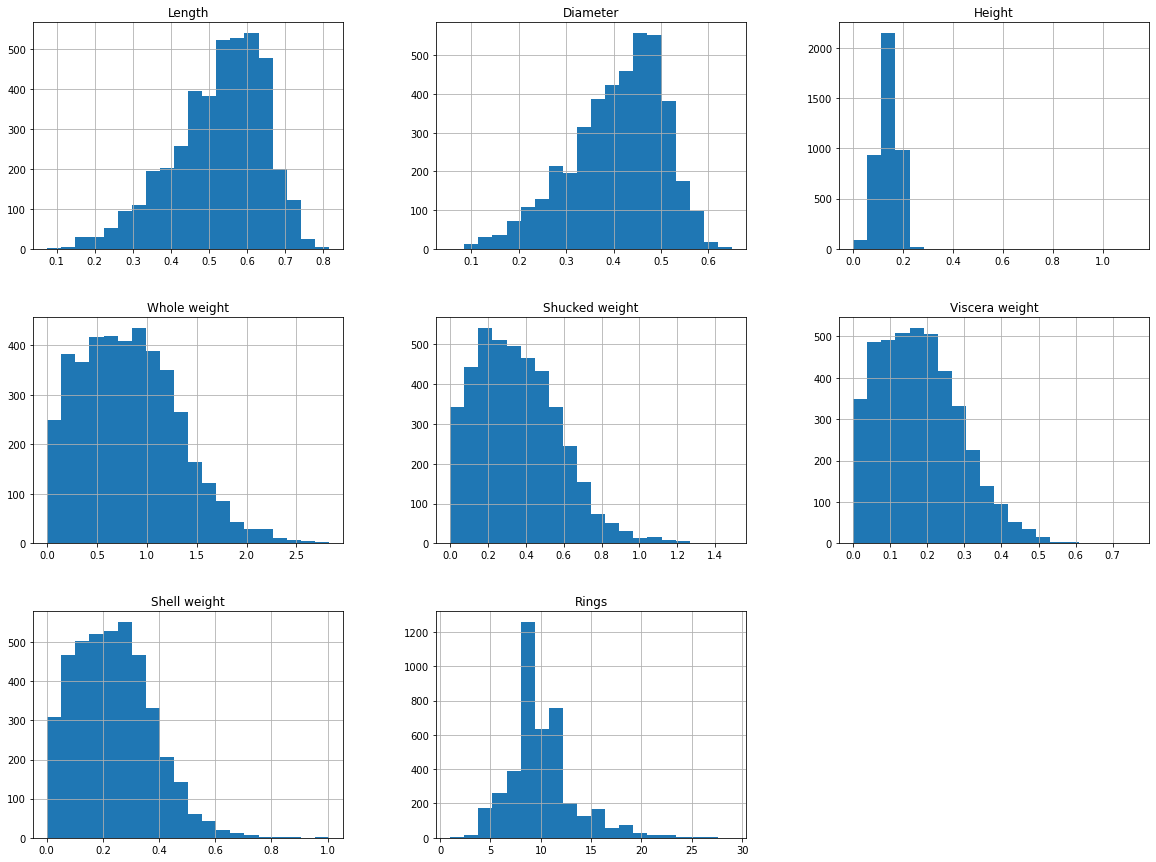

In [55]:
abalone.hist(bins=20, figsize=(20, 15))
plt.show()

#### Remove records with abnormal height

In [56]:
threshold = abalone["Height"].mean() + 3 * abalone["Height"].std()

In [57]:
abalone = abalone.query(f'Height < {threshold}').reset_index(drop=True)

### Create a test set

In [58]:
test_set, train_set = train_test_split(abalone, train_size=0.2)

In [63]:
abalone = train_set.copy()

### Looking for Correlations

In [64]:
corr_matrix = abalone.corr()

In [65]:
corr_matrix["Rings"].sort_values(ascending=False)

Rings             1.000000
Shell weight      0.633366
Height            0.614749
Diameter          0.577136
Length            0.560704
Whole weight      0.547425
Viscera weight    0.511377
Shucked weight    0.427966
Name: Rings, dtype: float64

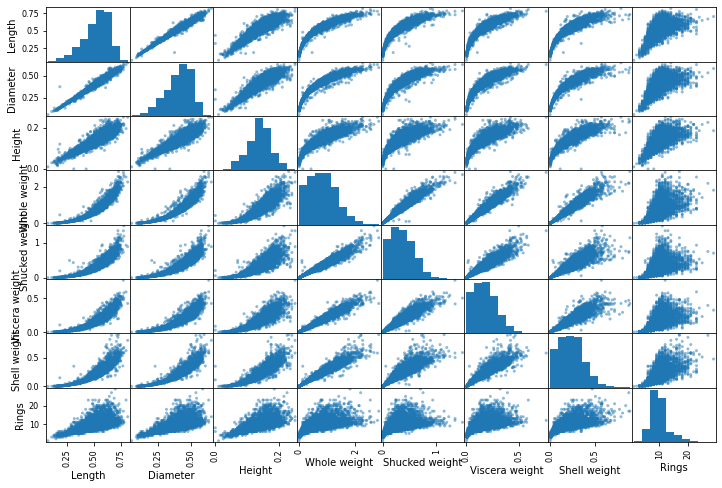

In [66]:
pd.plotting.scatter_matrix(abalone, figsize=(12, 8))
plt.show()

### Experimenting with attribute combinations

In [70]:
abalone["length_to_diameter"] = abalone["Length"] / abalone["Diameter"]
abalone["height_to_weight"] = abalone["Height"] / abalone["Whole weight"]
abalone["shell_to_whole"] = abalone["Shell weight"] / abalone["Whole weight"]

In [71]:
corr_matrix = abalone.corr()

In [72]:
corr_matrix["Rings"].sort_values(ascending=False)

Rings                 1.000000
Shell weight          0.633366
Height                0.614749
Diameter              0.577136
Length                0.560704
Whole weight          0.547425
Viscera weight        0.511377
Shucked weight        0.427966
shell_to_whole        0.104239
length_to_diameter   -0.346308
height_to_weight     -0.436458
Name: Rings, dtype: float64

### Prepare the data for machine learning algorithms

In [73]:
abalone = train_set.drop("Rings", axis=1)
abalone_labels = train_set["Rings"].copy()

### Handling text and categorical variables

In [90]:
abalone["Sex"].value_counts().sort_values(ascending=False)

M    1218
I    1073
F    1049
Name: Sex, dtype: int64

In [76]:
abalone_cat = abalone[["Sex"]]

In [86]:
one_hot_encoder = OneHotEncoder()

In [87]:
abalone_cat_encoded = one_hot_encoder.fit_transform(abalone_cat)

In [91]:
one_hot_encoder.categories_

[array(['F', 'I', 'M'], dtype=object)]

### Transformation pipelines

In [94]:
num_attribs = list(abalone.drop("Sex", axis=1))
cat_attribs = ["Sex"]

full_pipeline = ColumnTransformer([
    ("num", StandardScaler(), num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

In [98]:
abalone_prepared = full_pipeline.fit_transform(abalone)

### Training and evaluating on the test set

In [101]:
lin_reg = LinearRegression()
lin_reg.fit(abalone_prepared, abalone_labels)

LinearRegression()

In [105]:
abalone_predictions = lin_reg.predict(abalone_prepared)

In [110]:
lin_mse = mean_squared_error(abalone_labels, abalone_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

2.1728243833028285

In [113]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(abalone_prepared, abalone_labels)

DecisionTreeRegressor()

In [114]:
abalone_predictions = tree_reg.predict(abalone_prepared)

In [115]:
tree_mse = mean_squared_error(abalone_labels, abalone_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse # overfitting

0.0

### Better evaluation using cross validation

In [117]:
scores = cross_val_score(tree_reg, abalone_prepared, abalone_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [118]:
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Std:', scores.std())

In [119]:
display_scores(tree_rmse_scores)

Scores: [3.03768743 3.02088538 3.38939876 3.32968863 3.12369733 2.98248379
 3.05929427 3.02929806 2.8605305  2.70893399]
Mean: 3.054189813761516
Std: 0.18893659413998387


In [120]:
lin_scores = cross_val_score(lin_reg, abalone_prepared, abalone_labels,
                         scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [1.94550701 2.09823576 2.47505183 2.37652263 2.39945602 1.99292892
 2.23022041 2.13883242 2.01531111 2.0761479 ]
Mean: 2.17482139911931
Std: 0.1767376550382285


In [123]:
forest_reg = RandomForestRegressor()
forest_reg.fit(abalone_prepared, abalone_labels)

RandomForestRegressor()

In [124]:
forest_scores = cross_val_score(forest_reg, abalone_prepared, abalone_labels,
                         scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [1.95251918 2.20298348 2.54098777 2.40998515 2.31750582 2.15736317
 2.16041961 2.12051584 1.96931164 2.02090171]
Mean: 2.185249337437964
Std: 0.18117655478947658


### Grid search

In [125]:
param_grid = [
    {"n_estimators": [3, 10, 30], "max_features": [2, 4, 6, 8]},
    {"bootstrap": [False], "n_estimators": [3, 10], "max_features": [2, 3, 4]}
]

In [126]:
forest_reg = RandomForestRegressor()

In [127]:
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)

In [128]:
grid_search.fit(abalone_prepared, abalone_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [129]:
grid_search.best_estimator_

RandomForestRegressor(max_features=2, n_estimators=30)

In [130]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

2.4865707173003804 {'max_features': 2, 'n_estimators': 3}
2.2670221043379546 {'max_features': 2, 'n_estimators': 10}
2.190592220864131 {'max_features': 2, 'n_estimators': 30}
2.4750719930119502 {'max_features': 4, 'n_estimators': 3}
2.252457739506665 {'max_features': 4, 'n_estimators': 10}
2.2053318019336894 {'max_features': 4, 'n_estimators': 30}
2.5229881216280523 {'max_features': 6, 'n_estimators': 3}
2.24255855269722 {'max_features': 6, 'n_estimators': 10}
2.198562026272309 {'max_features': 6, 'n_estimators': 30}
2.5474146418055756 {'max_features': 8, 'n_estimators': 3}
2.283486015554624 {'max_features': 8, 'n_estimators': 10}
2.199058121126667 {'max_features': 8, 'n_estimators': 30}
2.5462455891239295 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
2.2835922169191356 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
2.4984159985205303 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
2.2717195207239658 {'bootstrap': False, 'max_features': 3, 'n_estima

In [131]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.08135162, 0.12362459, 0.15127295, 0.15781141, 0.14782589,
       0.11684192, 0.17971588, 0.00887561, 0.02225683, 0.0104233 ])

In [142]:
cat_attribs = full_pipeline.named_transformers_['cat'].categories_[0].tolist()

In [144]:
attribs = num_attribs + cat_attribs

In [145]:
sorted(zip(feature_importances, attribs), reverse=True)

[(0.17971587844962497, 'Shell weight'),
 (0.1578114139200424, 'Whole weight'),
 (0.15127295042173622, 'Height'),
 (0.14782588722091655, 'Shucked weight'),
 (0.12362458968019903, 'Diameter'),
 (0.11684192277073102, 'Viscera weight'),
 (0.08135161669933737, 'Length'),
 (0.02225683426979795, 'I'),
 (0.010423295840213896, 'M'),
 (0.008875610727400719, 'F')]

In [148]:
param_grid = [
    {"fit_intercept": [True], "normalize": [True, False], "positive": [True, False]},
    {"fit_intercept": [False], "positive": [True, False]}
]

In [149]:
lin_reg = LinearRegression()

In [150]:
grid_search = GridSearchCV(lin_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)

In [151]:
grid_search.fit(abalone_prepared, abalone_labels)

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid=[{'fit_intercept': [True], 'normalize': [True, False],
                          'positive': [True, False]},
                         {'fit_intercept': [False], 'positive': [True, False]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [152]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

2.4636021333206255 {'fit_intercept': True, 'normalize': True, 'positive': True}
2.185230744506176 {'fit_intercept': True, 'normalize': True, 'positive': False}
2.4636021333206255 {'fit_intercept': True, 'normalize': False, 'positive': True}
2.185230744506176 {'fit_intercept': True, 'normalize': False, 'positive': False}
2.463602133320622 {'fit_intercept': False, 'positive': True}
2.185230744506175 {'fit_intercept': False, 'positive': False}


### Evaluate your system on the test set

In [154]:
final_model = grid_search.best_estimator_

In [156]:
X_test = test_set.drop("Rings", axis=1)
y_test = test_set["Rings"].copy()
X_test_prepared = full_pipeline.transform(X_test)

In [157]:
final_predictions = final_model.predict(X_test_prepared)

In [158]:
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

2.2014762049741976

In [161]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([2.02526685, 2.36459069])